# Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from itertools import cycle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Preprocessing

In [18]:
path = 'train.csv'
df = pd.read_csv(path)
df = df[df['original'] == 1]

In [19]:
# Detect and process outliers
df.loc[:, '7'] = df['7'].apply(lambda x: x / 10 if x > 300 else x)
df.loc[:, '7'] = df['7'].apply(lambda x: x / 100 if x > 300 else x)

In [20]:
# 4-a Imputation & interpolation
df = df.interpolate()
df = df.fillna(df.mean())

# Remove Outliers - Not used
# After many attempts, I didn't used quantile function because the performance of removing outliers using quartiles was worse than not using.

# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]


# 4-b Data balancing with SMOTE
df['label'] = df['timestamp(day)'].apply(lambda x: -3 if x <= -3 else x)
df_label = df['label']
df_label_before_preprocessing = df_label

df_origin = pd.DataFrame(df)

df_features = df.drop(columns=['timestamp(day)', 'timestamp(hr)', 'original', 'label'])

smote = SMOTE()

df_features, df_label = smote.fit_resample(df_features, df_label)

# EDA


In [106]:
# 5.1 - How many patients are there?

num_patients = df_origin[(df_origin['timestamp(day)']==0) & (df_origin['timestamp(hr)']==0)].shape[0]
print(f"Number of patients: {num_patients}")

Number of patients: 4156


In [107]:
# 5.2 - What are the mean and median value of the label (day)?

mean_label = df_label_before_preprocessing.mean()
median_label = df_label_before_preprocessing.median()
print("Before Preprocessing")
print(f"Mean label : {mean_label}, Median label : {median_label}")


mean_label = df_label.mean()
median_label = df_label.median()
print("After Preprocessing")
print(f"Mean label : {mean_label}, Median label : {median_label}")


Before Preprocessing
Mean label : -1.3425082899369851, Median label : -1.0
After Preprocessing
Mean label : -1.5, Median label : -1.5


In [108]:
# 5.3 - Perform EDA and calculate the statistics of the dataset: mean, std,correlations among features, etc. (e.g.There are 34 features and you have to find the correlations among each feature (34 by 34 correlation matrix)).

desc = df_features.describe()
print(desc)

                   1              2              3              4   
count  252340.000000  252340.000000  252340.000000  252340.000000  \
mean        0.587855      65.473693      65.592411     116.774150   
std         0.486199      14.116004      14.482135      27.714659   
min         0.000000      20.000000       0.000000       0.000000   
25%         0.000000      57.000000      56.000000     102.000000   
50%         1.000000      68.000000      65.000000     115.000000   
75%         1.000000      76.000000      74.855330     130.000000   
max         1.000000      99.000000     802.000000    7652.000000   

                   5              6              7              8   
count  252340.000000  252340.000000  252340.000000  252340.000000  \
mean       97.873978      20.724496      36.946602       0.041015   
std        28.632424       4.910588       0.853762       0.079178   
min         0.000000       0.000000       0.000000       0.000000   
25%        82.000000      18.0000

In [109]:
correlation_matrix = df_features.corr()
print(correlation_matrix)

           1         2         3         4         5         6         7   
1   1.000000  0.011595  0.020414  0.003415  0.001509  0.044641 -0.042868  \
2   0.011595  1.000000 -0.154965  0.058231 -0.094839 -0.010968 -0.066079   
3   0.020414 -0.154965  1.000000  0.409073  0.079494 -0.019655  0.089238   
4   0.003415  0.058231  0.409073  1.000000 -0.044967  0.003675  0.005047   
5   0.001509 -0.094839  0.079494 -0.044967  1.000000  0.187506  0.155123   
6   0.044641 -0.010968 -0.019655  0.003675  0.187506  1.000000  0.053988   
7  -0.042868 -0.066079  0.089238  0.005047  0.155123  0.053988  1.000000   
8  -0.012060  0.017090 -0.029828 -0.015574  0.053538  0.029781 -0.034720   
9  -0.017336 -0.041926 -0.002737 -0.019100  0.060442  0.028033  0.003914   
10  0.020052 -0.007433 -0.028700 -0.009079  0.102860  0.065442  0.049664   
11  0.025266 -0.027992 -0.056739 -0.050589  0.132309  0.079096 -0.033859   
12  0.024714 -0.034726 -0.064279 -0.051754  0.138357  0.086533 -0.023834   
13  0.023662

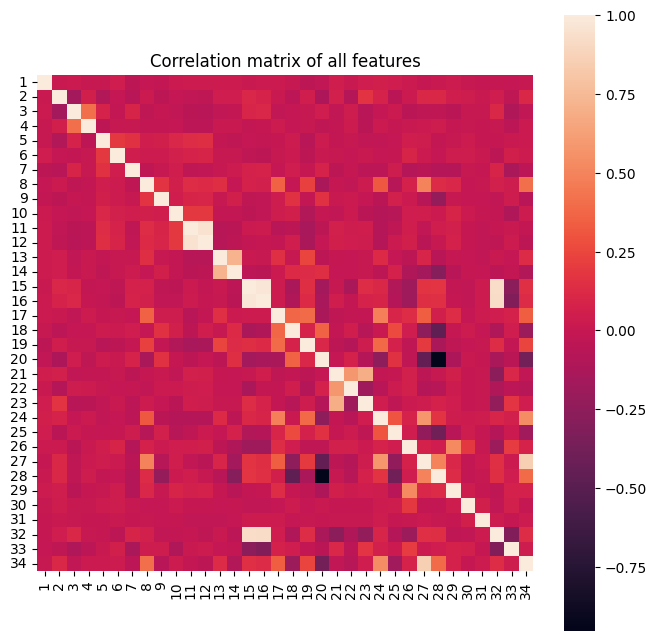

In [110]:
plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix, square=True)
plt.title('Correlation matrix of all features')
plt.show()

In [21]:
# 5.5 - Perform feature engineering/selection/importance (you may remove no more than 5 features). You can employ any well-known feature engineering methods (PCA, clustering, etc.). Justify your choices and processes.

rf = RandomForestClassifier()
rf.fit(df_features, df_label)
importances = rf.feature_importances_

feature_importances = pd.DataFrame({'feature': df_features.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=True)
print(feature_importances)

features_dropped = df_features.drop(columns=feature_importances['feature'][:5])
features_dropped

   feature  importance
0        1    0.007831
2        3    0.013019
5        6    0.013441
6        7    0.014358
3        4    0.014794
4        5    0.019166
15      16    0.026731
31      32    0.027301
7        8    0.027443
14      15    0.028144
8        9    0.028795
27      28    0.029528
26      27    0.030040
33      34    0.030792
13      14    0.030995
1        2    0.031228
10      11    0.031247
12      13    0.031334
19      20    0.031728
23      24    0.031898
24      25    0.031906
11      12    0.031928
18      19    0.032763
21      22    0.032867
16      17    0.032954
17      18    0.033427
20      21    0.033580
25      26    0.033953
28      29    0.034366
22      23    0.034875
32      33    0.038135
9       10    0.039921
29      30    0.042786
30      31    0.046728


,2,5,8,9,10,11,12,13,14,15,...,25,26,27,28,29,30,31,32,33,34
0,62.000000,97.871270,0.020000,0.300000,131.775089,9.586726,11.529327,0.020000,0.300000,34.700000,...,7.400000,10.000000,6.100000,78.600000,59.581579,10.900000,120.354606,4.110000,13.600000,7.750000
1,62.000000,106.000000,0.020000,0.283333,131.775089,9.586726,11.529327,0.016667,0.250000,35.100000,...,6.916667,10.016667,6.388333,79.766667,59.581579,10.983333,120.354606,4.140000,13.633333,7.983333
2,62.000000,100.000000,0.020000,0.266667,131.775089,9.586726,11.529327,0.013333,0.200000,35.500000,...,6.433333,10.033333,6.676667,80.933333,59.581579,11.066667,120.354606,4.170000,13.666667,8.216667
3,62.000000,94.000000,0.020000,0.250000,131.775089,9.586726,11.529327,0.010000,0.150000,35.900000,...,5.950000,10.050000,6.965000,82.100000,59.581579,11.150000,120.354606,4.200000,13.700000,8.450000
4,62.000000,98.000000,0.020000,0.233333,131.775089,9.586726,11.529327,0.006667,0.100000,36.300000,...,5.466667,10.066667,7.253333,83.266667,59.581579,11.233333,120.354606,4.230000,13.733333,8.683333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252335,71.617997,77.561970,0.015055,0.112354,114.222115,3.286047,4.566964,0.015693,0.151683,30.698557,...,3.665201,8.874916,9.212894,88.131481,54.329008,14.812326,161.355292,3.423724,16.672707,10.399548
252336,79.000000,89.379124,0.051349,0.278372,259.181497,4.996952,6.034864,0.154326,0.964885,30.689060,...,3.002798,8.864885,14.764355,90.683465,53.146305,10.968718,61.936020,3.396743,13.535115,16.264380
252337,47.000000,70.663100,0.030000,0.199997,154.300019,2.249999,3.349990,0.159996,1.499958,41.800021,...,3.749978,7.949993,10.060092,76.000282,50.749999,9.737647,103.704558,4.125002,13.949993,12.925073
252338,84.000000,94.973889,0.012456,0.124565,27.971535,1.514023,2.438588,0.046141,0.473694,31.766634,...,3.063153,8.875435,9.517669,83.147292,60.103579,9.135699,159.985616,3.344207,16.126306,11.425386


In [22]:
# Print Functions

def roc_curves(y_test_bin, y_pred_bin):
    # design ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Print ROC curves
    plt.figure()
    lw = 2

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(4), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()    
    
def print_Metrics(y_test, y_pred, accuracy, f1, precision, recall):
    # Print evaluation metrics
    print("Accuracy: ", accuracy)
    print("F1 score: ", f1)
    print("Precision: ", precision)
    print("Recall: ", recall)

    # Print confusion matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Print classification report
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

# Model Selection



In [23]:
# Label Encoding

le = LabelEncoder()
df_label_encoded = le.fit_transform(df_label)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features_dropped, df_label, test_size=0.2, random_state=42)

Accuracy:  0.9640564317983673
F1 score:  0.9641688696931087
Precision:  0.9645243987383777
Recall:  0.9640564317983673
Confusion Matrix:
 [[12255   110     4   177]
 [  114 12180   125   228]
 [   20   138 11933   519]
 [   86    21   272 12286]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.98      0.98      0.98     12546
        -2.0       0.98      0.96      0.97     12647
        -1.0       0.97      0.95      0.96     12610
         0.0       0.93      0.97      0.95     12665

    accuracy                           0.96     50468
   macro avg       0.96      0.96      0.96     50468
weighted avg       0.96      0.96      0.96     50468



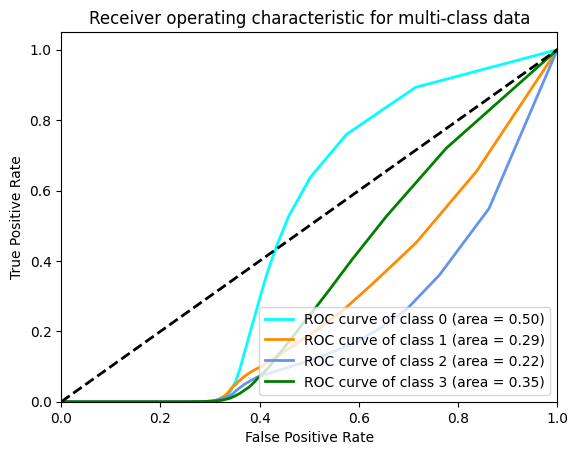

In [153]:
# Model 1 - RandomForestClassifier

# Define the model
rfc = RandomForestClassifier(class_weight='balanced')

# Fit the model
rfc.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = rfc.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test, classes=[0, -1, -2, -3])
y_pred_bin = rfc.predict_proba(X_test)
roc_curves(y_test_bin, y_pred_bin)

c:\Users\frica\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy:  0.7598874534358405
F1 score:  0.7596312002677985
Precision:  0.7618414877279795
Recall:  0.7598874534358405
Confusion Matrix:
 [[10354   683   411  1098]
 [ 1052  9783   797  1015]
 [  867  1077  8576  2090]
 [ 1073   556  1399  9637]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.78      0.83      0.80     12546
        -2.0       0.81      0.77      0.79     12647
        -1.0       0.77      0.68      0.72     12610
         0.0       0.70      0.76      0.73     12665

    accuracy                           0.76     50468
   macro avg       0.76      0.76      0.76     50468
weighted avg       0.76      0.76      0.76     50468



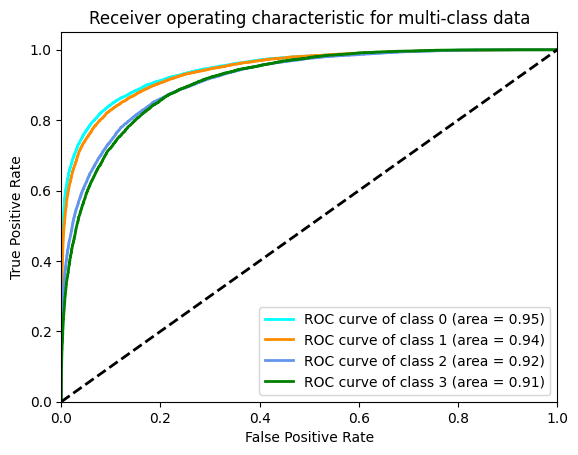

In [156]:
# Encode the labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Model 2 - XGBClassifier

# Define the model
xgbc = xgb.XGBClassifier(use_label_encoder=False)

# Fit the model
xgbc.fit(X_train, y_train_encoded)

# Predict and evaluate on test set
y_pred_encoded = xgbc.predict(X_test)

# Decode y_test and y_pred
y_test = le.inverse_transform(y_test_encoded)
y_pred = le.inverse_transform(y_pred_encoded)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
f1 = f1_score(y_test_encoded, y_pred_encoded, average='macro', zero_division=1)
precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=1)
recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=1)

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])
y_pred_bin = xgbc.predict_proba(X_test)
roc_curves(y_test_bin, y_pred_bin)

c:\Users\frica\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.32462154236347784
F1 score:  0.2955368443091456
Precision:  0.30936353991846344
Recall:  0.32462154236347784
Confusion Matrix:
 [[6595 1378 1418 3155]
 [5390 1424 1780 4053]
 [4452 1345 2041 4772]
 [3407 1118 1817 6323]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.33      0.53      0.41     12546
        -2.0       0.27      0.11      0.16     12647
        -1.0       0.29      0.16      0.21     12610
         0.0       0.35      0.50      0.41     12665

    accuracy                           0.32     50468
   macro avg       0.31      0.32      0.30     50468
weighted avg       0.31      0.32      0.30     50468



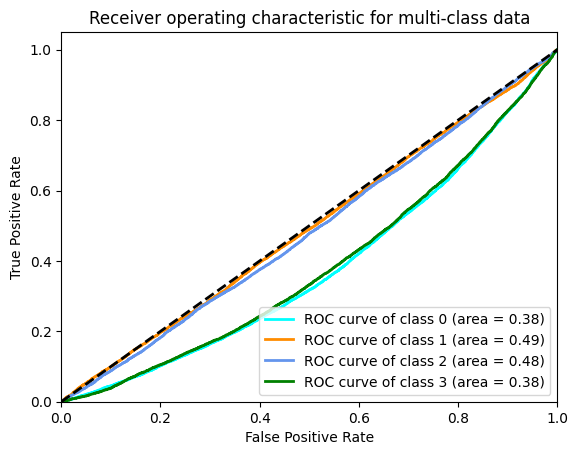

In [157]:
# Model 3 - Logistic Regression

# Define and fit the model

logreg = LogisticRegression(penalty='l2', C=0.001, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test, classes=[0, -1, -2, -3])
y_pred_bin = logreg.predict_proba(X_test)
roc_curves(y_test_bin, y_pred_bin)

Accuracy:  0.912399936593485
F1 score:  0.9123225031728306
Precision:  0.912262094624826
Recall:  0.912399936593485
Confusion Matrix:
 [[11727   283   169   367]
 [  253 11827   296   271]
 [  200   318 11442   650]
 [  445   350   819 11051]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.93      0.93      0.93     12546
        -2.0       0.93      0.94      0.93     12647
        -1.0       0.90      0.91      0.90     12610
         0.0       0.90      0.87      0.88     12665

    accuracy                           0.91     50468
   macro avg       0.91      0.91      0.91     50468
weighted avg       0.91      0.91      0.91     50468



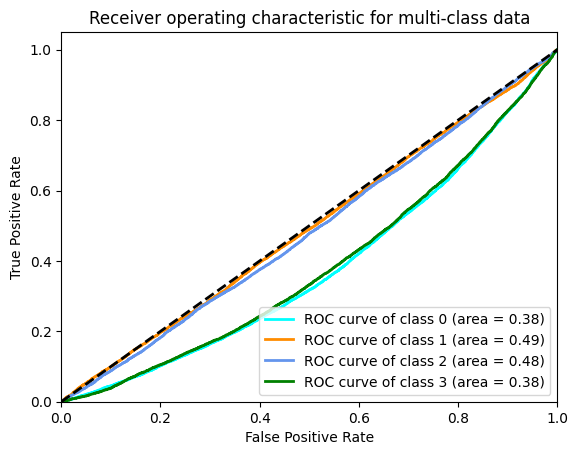

In [158]:
# Model 4 - DecisionTree

# Define the model
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test, classes=[0, -1, -2, -3])
y_pred_bin = logreg.predict_proba(X_test)
roc_curves(y_test_bin, y_pred_bin)

Learning rate set to 0.103725
0:	learn: 1.3812715	total: 175ms	remaining: 2m 55s
1:	learn: 1.3766078	total: 342ms	remaining: 2m 50s
2:	learn: 1.3725664	total: 536ms	remaining: 2m 57s
3:	learn: 1.3686498	total: 764ms	remaining: 3m 10s
4:	learn: 1.3655712	total: 966ms	remaining: 3m 12s
5:	learn: 1.3621323	total: 1.19s	remaining: 3m 16s
6:	learn: 1.3592191	total: 1.36s	remaining: 3m 13s
7:	learn: 1.3564972	total: 1.52s	remaining: 3m 8s
8:	learn: 1.3536381	total: 1.67s	remaining: 3m 3s
9:	learn: 1.3507717	total: 1.89s	remaining: 3m 7s
10:	learn: 1.3484166	total: 2.07s	remaining: 3m 6s
11:	learn: 1.3460446	total: 2.24s	remaining: 3m 4s
12:	learn: 1.3443929	total: 2.38s	remaining: 3m
13:	learn: 1.3423006	total: 2.55s	remaining: 2m 59s
14:	learn: 1.3402787	total: 2.72s	remaining: 2m 58s
15:	learn: 1.3384220	total: 2.87s	remaining: 2m 56s
16:	learn: 1.3364009	total: 3s	remaining: 2m 53s
17:	learn: 1.3347414	total: 3.18s	remaining: 2m 53s
18:	learn: 1.3326931	total: 3.33s	remaining: 2m 52s
19:	

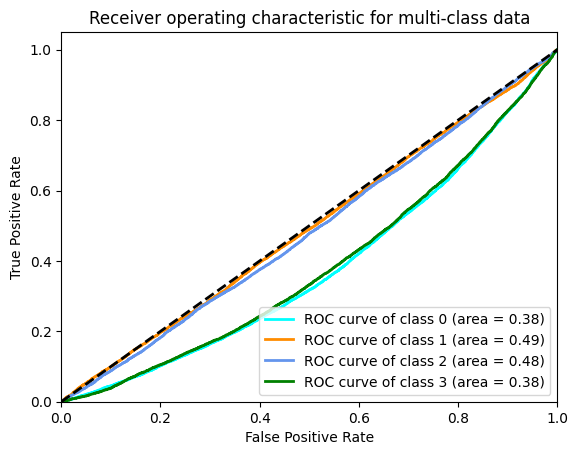

Accuracy:  0.8108306253467544
F1 score:  0.8107266950282132
Precision:  0.8112388766477736
Recall:  0.8108306253467544
Confusion Matrix:
 [[10867   641   187   851]
 [  607 10696   666   678]
 [  434   980  9393  1803]
 [  903   309  1488  9965]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.85      0.87      0.86     12546
        -2.0       0.85      0.85      0.85     12647
        -1.0       0.80      0.74      0.77     12610
         0.0       0.75      0.79      0.77     12665

    accuracy                           0.81     50468
   macro avg       0.81      0.81      0.81     50468
weighted avg       0.81      0.81      0.81     50468



In [162]:
# Model 5 - Catboost

# Define the model
cbc = CatBoostClassifier(random_state=42)
cbc.fit(X_train, y_train)
y_pred = cbc.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test, classes=[0, -1, -2, -3])
y_pred_bin = logreg.predict_proba(X_test)
roc_curves(y_test_bin, y_pred_bin)

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

Accuracy:  0.2999524451137354
F1 score:  0.255079239027987
Precision:  0.2931114840131611
Recall:  0.2999524451137354
Confusion Matrix:
 [[8278  455 1720 2093]
 [7544  458 2005 2640]
 [6668  464 2302 3176]
 [5893  364 2308 4100]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.29      0.66      0.40     12546
        -2.0       0.26      0.04      0.06     12647
        -1.0       0.28      0.18      0.22     12610
         0.0       0.34      0.32      0.33     12665

    accuracy                           0.30     50468
   macro avg       0.29      0.30      0.26     50468
weighted avg       0.29      0.30      0.25     50468



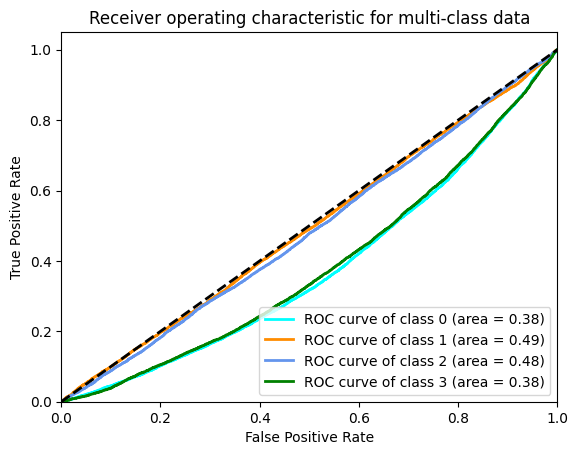

In [160]:
# Model 6 - GaussianNB

# Create the model
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test, classes=[0, -1, -2, -3])
y_pred_bin = logreg.predict_proba(X_test)
roc_curves(y_test_bin, y_pred_bin)

Accuracy:  0.9390504874375842
F1 score:  0.9389911958013661
Precision:  0.939539975161425
Recall:  0.9390504874375842
Confusion Matrix:
 [[12008   352    65   121]
 [  141 12205   262    39]
 [   57   357 11813   383]
 [  302   217   780 11366]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.96      0.96      0.96     12546
        -2.0       0.93      0.97      0.95     12647
        -1.0       0.91      0.94      0.93     12610
         0.0       0.95      0.90      0.93     12665

    accuracy                           0.94     50468
   macro avg       0.94      0.94      0.94     50468
weighted avg       0.94      0.94      0.94     50468



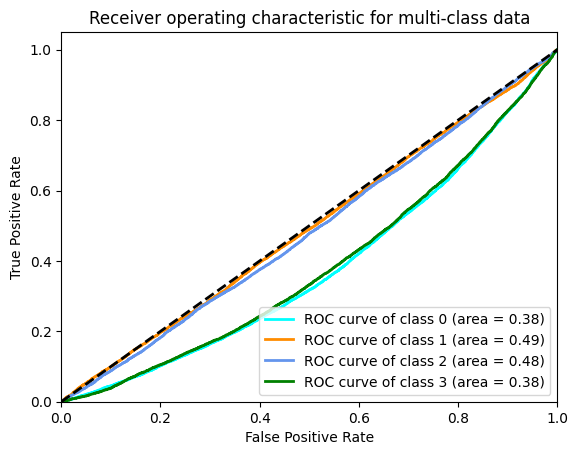

In [161]:
# Model 7 - Knn

# Create the model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test, classes=[0, -1, -2, -3])
y_pred_bin = logreg.predict_proba(X_test)
roc_curves(y_test_bin, y_pred_bin)

# Model Tuning



Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy:  0.9637790282951574
F1 score:  0.9639422091517865
Precision:  0.9641955251395563
Recall:  0.9637790282951574
Confusion Matrix:
 [[12212   128     3   165]
 [  102 12101   139   223]
 [   15   132 11989   520]
 [   80    22   299 12338]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.98      0.98      0.98     12508
        -2.0       0.98      0.96      0.97     12565
        -1.0       0.96      0.95      0.96     12656
         0.0       0.93      0.97      0.95     12739

    accuracy                           0.96     50468
   macro avg       0.96      0.96      0.96     50468
weighted avg       0.96      0.96      0.96     50468



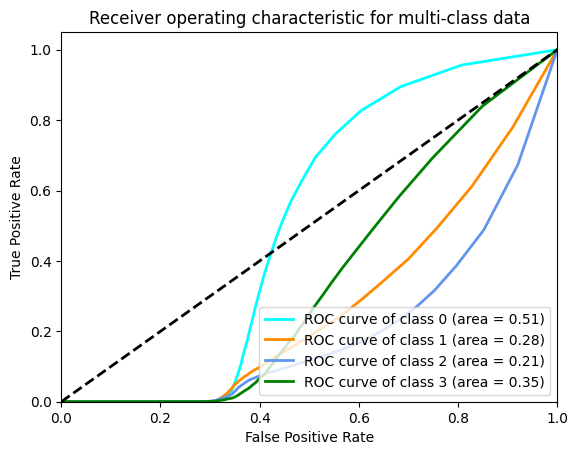

In [170]:
# RandomForest GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# Create a base model
rfc = RandomForestClassifier(class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

# Split the data into a smaller training set and a validation set
X_train_small, X_val, y_train_small, y_val = train_test_split(features_dropped, df_label, test_size=0.2, random_state=123)

# Fit the grid search to the data
grid_search.fit(X_train_small, y_train_small)

# Get the best parameters
print("Best parameters: ", grid_search.best_params_)

# Create a new RFC with best parameters
best_rfc = grid_search.best_estimator_

# Evaluate on the validation set
y_pred = best_rfc.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

# Print metrics
print_Metrics(y_val, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_val_bin = label_binarize(y_val, classes=[0, -1, -2, -3])
y_pred_bin = best_rfc.predict_proba(X_val)
roc_curves(y_val_bin, y_pred_bin)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy:  0.913271776175002
F1 score:  0.9132893257756378
Precision:  0.9131482652334979
Recall:  0.913271776175002
Confusion Matrix:
 [[11718   307   148   335]
 [  239 11765   299   262]
 [  169   335 11482   670]
 [  424   342   847 11126]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.93      0.94      0.94     12508
        -2.0       0.92      0.94      0.93     12565
        -1.0       0.90      0.91      0.90     12656
         0.0       0.90      0.87      0.89     12739

    accuracy                           0.91     50468
   macro avg       0.91      0.91      0.91     50468
weighted avg       0.91      0.91      0.91     50468



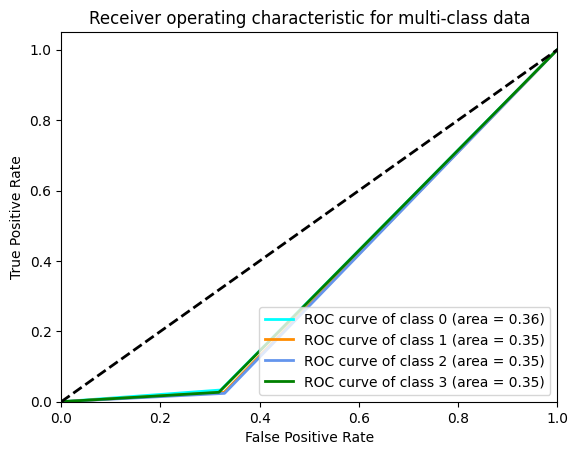

In [171]:
# DecisionTree GridSearchCV

# Define the parameter grid for DecisionTree
param_grid_dtc = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
dtc = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid_dtc, 
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

# Fit the grid search to the data
grid_search_dtc.fit(X_train_small, y_train_small)

# Get the best parameters
print("Best parameters: ", grid_search_dtc.best_params_)

# Create a new DTC with best parameters
best_dtc = grid_search_dtc.best_estimator_

# Evaluate on the validation set
y_pred_dtc = best_dtc.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_dtc)
f1 = f1_score(y_val, y_pred_dtc, average='macro')
precision = precision_score(y_val, y_pred_dtc, average='weighted')
recall = recall_score(y_val, y_pred_dtc, average='weighted')

# Print metrics
print_Metrics(y_val, y_pred_dtc, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_val_bin = label_binarize(y_val, classes=[0, -1, -2, -3])
y_pred_bin_dtc = best_dtc.predict_proba(X_val)
roc_curves(y_val_bin, y_pred_bin_dtc)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy:  0.9673654593009432
F1 score:  0.9674285251331971
Precision:  0.967508191794051
Recall:  0.9673654593009432
Confusion Matrix:
 [[12241   197    22    48]
 [   89 12321   137    18]
 [   11   176 12191   278]
 [   95    62   514 12068]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.98      0.98      0.98     12508
        -2.0       0.97      0.98      0.97     12565
        -1.0       0.95      0.96      0.96     12656
         0.0       0.97      0.95      0.96     12739

    accuracy                           0.97     50468
   macro avg       0.97      0.97      0.97     50468
weighted avg       0.97      0.97      0.97     50468



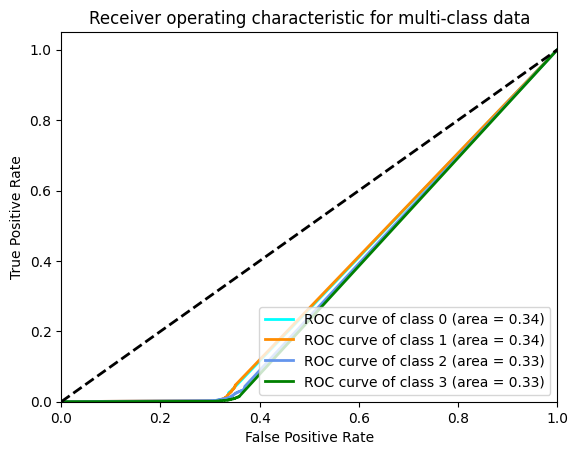

In [172]:
# KNN GridSearchCV

# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create a base model
knn = KNeighborsClassifier()

# Instantiate the grid search model
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, 
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

# Fit the grid search to the data
grid_search_knn.fit(X_train_small, y_train_small)

# Get the best parameters
print("Best parameters: ", grid_search_knn.best_params_)

# Create a new KNN with best parameters
best_knn = grid_search_knn.best_estimator_

# Evaluate on the validation set
y_pred_knn = best_knn.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_knn)
f1 = f1_score(y_val, y_pred_knn, average='macro')
precision = precision_score(y_val, y_pred_knn, average='weighted')
recall = recall_score(y_val, y_pred_knn, average='weighted')

# Print metrics
print_Metrics(y_val, y_pred_knn, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_val_bin = label_binarize(y_val, classes=[0, -1, -2, -3])
y_pred_bin_knn = best_knn.predict_proba(X_val)
roc_curves(y_val_bin, y_pred_bin_knn)

Accuracy:  0.9636205120076088
F1 score:  0.9636563082845249
Precision:  0.9636558184571179
Recall:  0.9636205120076088
Confusion Matrix:
 [[12257   136    28   125]
 [  126 12237   161   123]
 [   36   160 12019   395]
 [  124    47   375 12119]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.98      0.98      0.98     12546
        -2.0       0.97      0.97      0.97     12647
        -1.0       0.96      0.95      0.95     12610
         0.0       0.95      0.96      0.95     12665

    accuracy                           0.96     50468
   macro avg       0.96      0.96      0.96     50468
weighted avg       0.96      0.96      0.96     50468



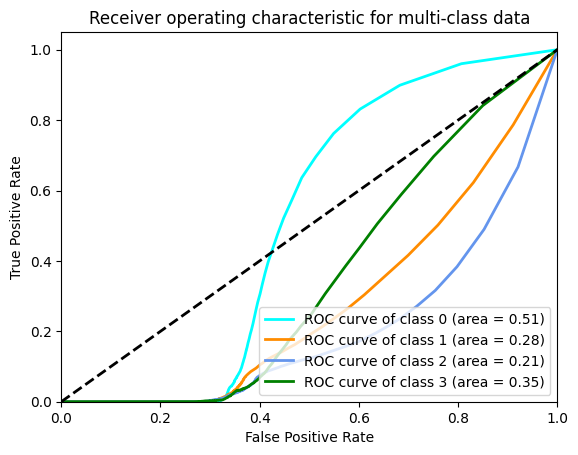

In [25]:
# Ensemble2

best_rfc = RandomForestClassifier(max_depth = None, min_samples_split = 2, n_estimators = 200)
best_dtc = DecisionTreeClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 2)
best_knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, weights = 'distance')

voting_clf2 = VotingClassifier(
    estimators=[('best_rfc', best_rfc), ('best_dtc', best_dtc), ('best_knn', best_knn)],
    voting='soft')

voting_clf2.fit(X_train, y_train)

y_pred = voting_clf2.predict(X_test)
y_pred_bin = voting_clf2.predict_proba(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test, classes=[0, -1, -2, -3])
roc_curves(y_test_bin, y_pred_bin)

# Model Evaluation / Metrics

In [26]:
# Load and preprocess test data 
test_path = 'test.csv'
df_test = pd.read_csv(test_path)

df_test = df_test[df_test['original'] == 1]
df_test = df_test.interpolate()
df_test = df_test.fillna(df.mean())

# Combine -3, -4, -5 into one class for 'timestamp(day)' (Test data)
df_test['label'] = df_test['timestamp(day)'].apply(lambda x: -3 if x <= -3 else x)
y_test = df_test['label']

# Drop unnecessary columns and less-important colums (Test data)
features_test = df_test.drop(columns=['timestamp(day)', 'timestamp(hr)', 'original', 'label'])
features_test = features_test.drop(columns=feature_importances['feature'][:5])

Accuracy:  0.37685077102660197
F1 score:  0.27416974286451556
Precision:  0.38076847645290196
Recall:  0.37685077102660197
Confusion Matrix:
 [[1067  586  866 2312]
 [ 320  215  282  837]
 [ 385  287  373 1018]
 [1216  685 1349 4479]]
Classification Report:
               precision    recall  f1-score   support

        -3.0       0.36      0.22      0.27      4831
        -2.0       0.12      0.13      0.13      1654
        -1.0       0.13      0.18      0.15      2063
         0.0       0.52      0.58      0.55      7729

    accuracy                           0.38     16277
   macro avg       0.28      0.28      0.27     16277
weighted avg       0.38      0.38      0.37     16277



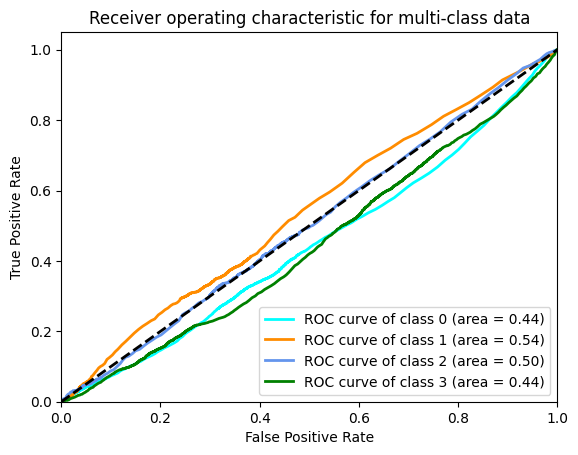

In [27]:
# Predict using the voting classifier
y_pred = voting_clf2.predict(features_test)
y_pred_bin = voting_clf2.predict_proba(features_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

# Print metrics
print_Metrics(y_test, y_pred, accuracy, f1, precision, recall)

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test, classes=[0, -1, -2, -3])
roc_curves(y_test_bin, y_pred_bin)